## <u>*Classsification Modelling for age category as a Target Feature*</u>

In [60]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os
import json

In [61]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

---

*Importing Data :*

In [62]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df=df[df["veh_value"] != 0]
df["veh_value"]=df["veh_value"]*10000
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,10600.0,0.303901,0.0,HBACK,3,F,C,2
1,10300.0,0.648871,0.0,HBACK,2,F,A,4
2,32600.0,0.569473,0.0,UTE,2,F,E,2
3,41400.0,0.317591,0.0,STNWG,2,F,D,2
4,7200.0,0.648871,0.0,HBACK,4,F,C,2


---

*Sorting Data :*

In [63]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,15900.0,0.229979,0.0,SEDAN,1,F,A,1
1,14600.0,0.221766,0.0,HBACK,1,F,A,1
2,15400.0,0.238193,0.0,SEDAN,1,F,A,1
3,15700.0,0.522930,0.0,SEDAN,1,F,A,1
4,14100.0,0.219028,0.0,HBACK,1,F,A,1


---

*Data Shape :*

In [64]:
df.shape

(67803, 8)

---

*Define categorical features and numerical features :*

In [65]:
categorical_features=df.select_dtypes(include=["object"])
numerical_features=df.select_dtypes(exclude=["object"])

print("we have {} numerical features : {}\n".format(numerical_features.shape[1],list(numerical_features.columns)))
print("we have {} categorical features : {}".format(categorical_features.shape[1],list(categorical_features.columns)))

we have 3 numerical features : ['veh_value', 'exposure', 'claimcst0']

we have 5 categorical features : ['veh_body', 'veh_age', 'gender', 'area', 'agecat']


---

In [66]:
import numpy as np
import scipy.stats as stats
threshold = np.percentile(df["claimcst0"], 95)
excesses = df["claimcst0"][df["claimcst0"] > threshold] - threshold
shape, loc, scale = stats.genpareto.fit(excesses)
extreme_values = stats.genpareto.ppf(0.99, shape, loc=loc, scale=scale) + threshold
claimcst0_outliers = df["claimcst0"][df["claimcst0"] > extreme_values]
df=df[df["claimcst0"].isin(list(claimcst0_outliers.values)) == False]

*Categorical features Frequency percenatge :*

In [67]:
for col in categorical_features:
    print(df[col].value_counts(normalize=True)*100)

veh_body
SEDAN    32.792979
HBACK    27.898813
STNWG    23.938344
UTE       6.764511
TRUCK     2.569511
HDTOP     2.326130
COUPE     1.150527
PANVN     1.109226
MIBUS     1.056125
MCARA     0.178479
CONVT     0.119478
BUS       0.056051
RDSTR     0.039826
Name: proportion, dtype: float64
veh_age
3    29.589203
4    27.887012
2    24.453131
1    18.070654
Name: proportion, dtype: float64
gender
F    56.909802
M    43.090198
Name: proportion, dtype: float64
area
C    30.282469
A    24.043071
B    19.657792
D    12.037761
E     8.711557
F     5.267350
Name: proportion, dtype: float64
agecat
4    23.861642
3    23.240652
2    18.976326
5    15.815326
6     9.651154
1     8.454901
Name: proportion, dtype: float64


---

*Visualizing numerical features :*

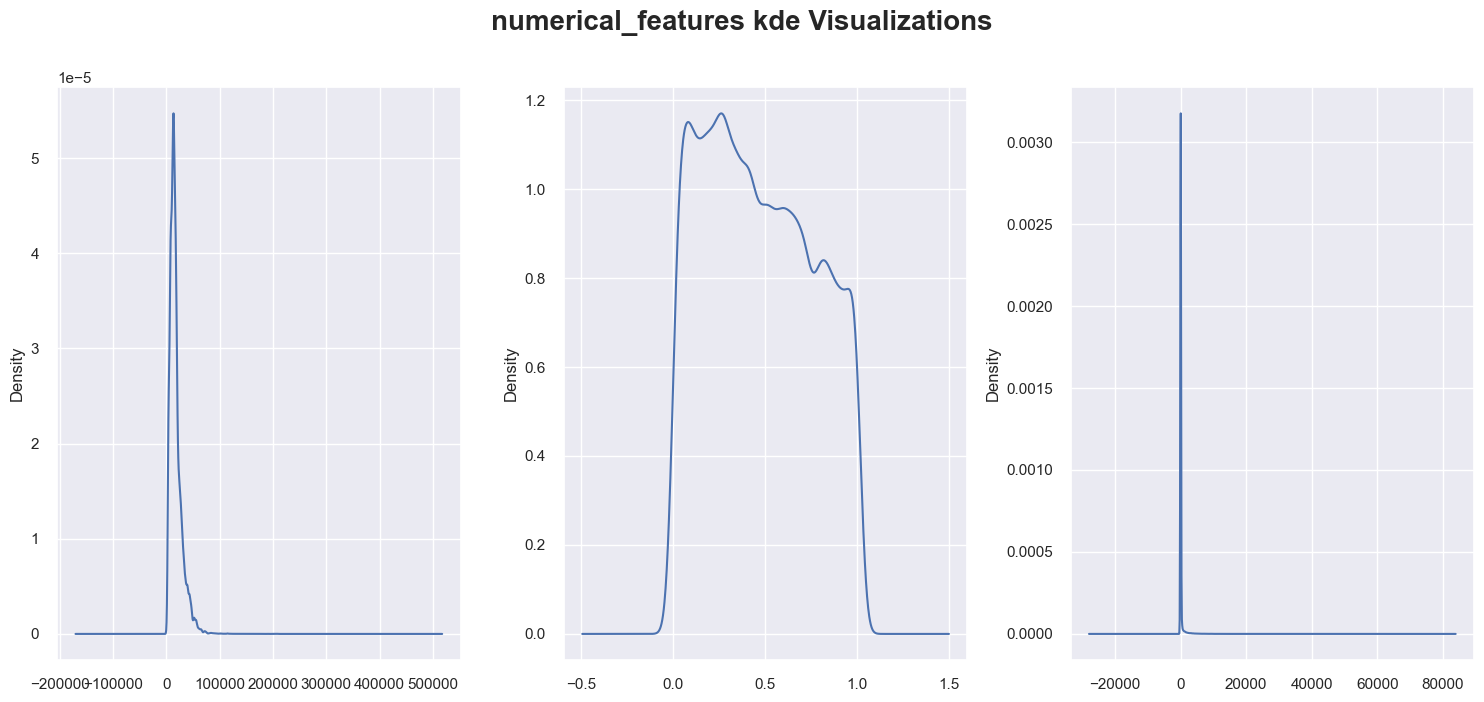

In [68]:
def plot_numerical_features(numerical_features,ChartType):
    nrows = 1
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))
    fig.suptitle(f"numerical_features {ChartType} Visualizations",fontsize=20,fontweight="bold",y=1.)
    
    axes = axes.flatten()

    for i, column in enumerate(numerical_features.columns):
        if i >= nrows * ncols:
            break 
        numerical_features[column].plot(ax=axes[i], kind=f"{ChartType}")
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_numerical_features.png',dpi=500);
        


    plt.tight_layout()
    plt.show()

plot_numerical_features(numerical_features[["veh_value","exposure","claimcst0"]],"kde")


---

*Visualizing categorical features :*

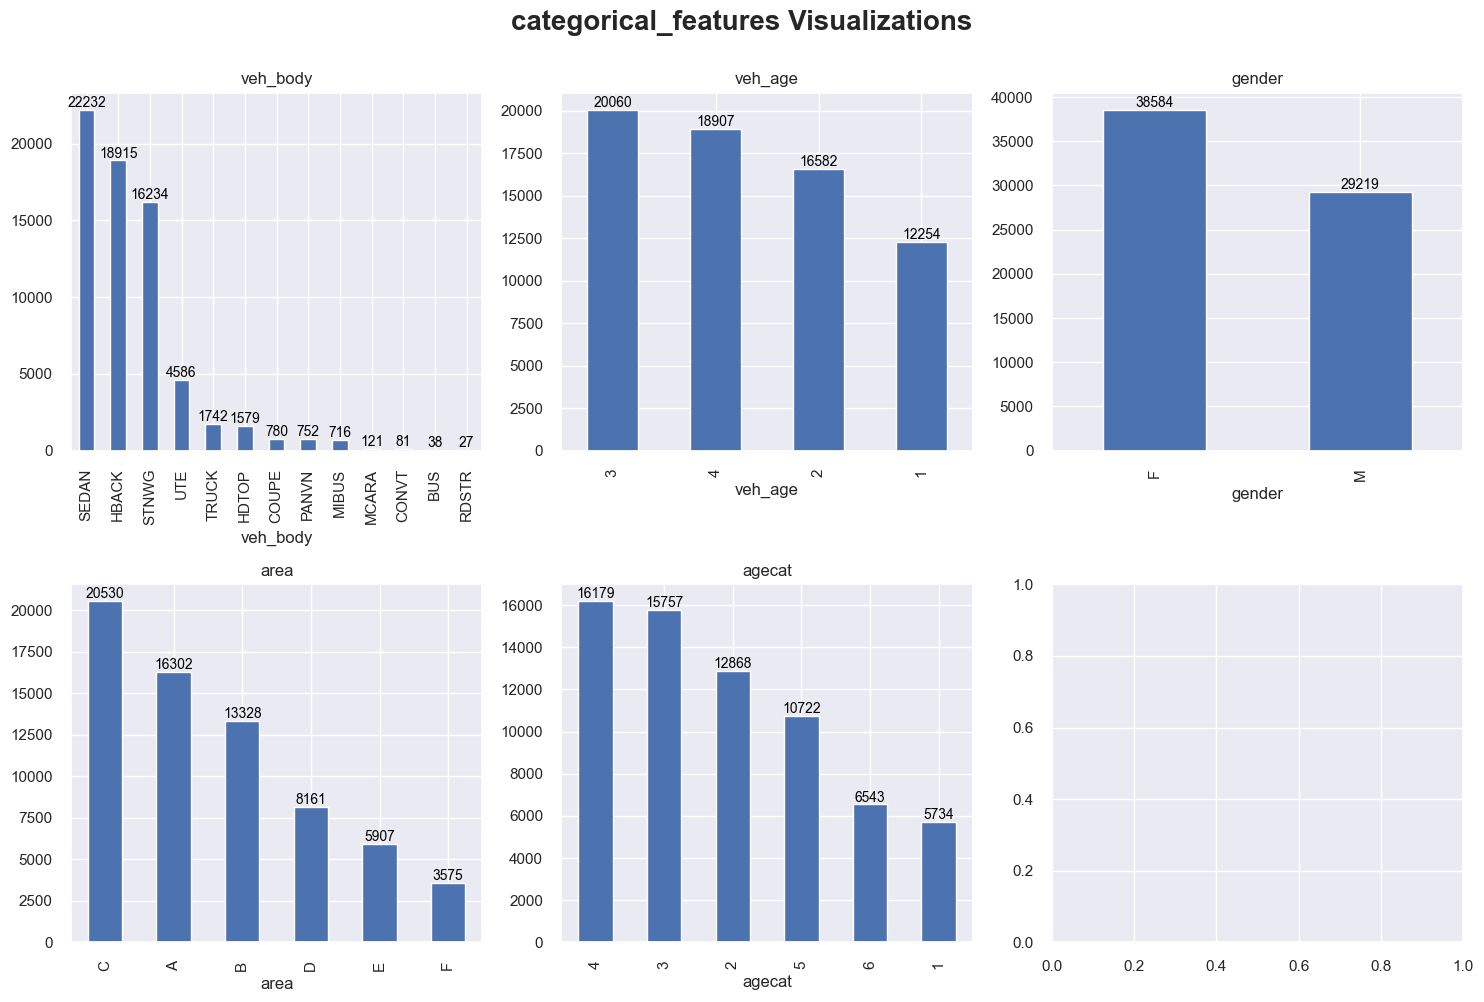

In [69]:
def plot_categorical_features(categorical_features):
    nrows = 2
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    fig.suptitle(f"categorical_features Visualizations",fontsize=20,fontweight="bold",y=1.)

    axes = axes.flatten()
    
    for i, column in enumerate(categorical_features.columns):
        if i >= nrows * ncols:
            break 
        ax = axes[i]
        counts = categorical_features[column].value_counts()
        counts.plot(kind='bar', ax=ax, title=column)
        
        for bar in ax.patches:
            ax.annotate(
                str(bar.get_height()),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points'
            )
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_categorical_features.png',dpi=500);
        
    plt.tight_layout()
    plt.show()

plot_categorical_features(categorical_features)    

---

*Define discretes feature and countinuous features :*

In [70]:
discrete_feature=[feature for feature in numerical_features if  len(df[feature].unique())<=25]
countinuous_feature=[feature for feature in numerical_features if  len(df[feature].unique())>25]

In [71]:

print("we have {} discrete feature : {}\n".format(len(discrete_feature),(discrete_feature)))
print("we have {} countinuous feature : {}".format(len(countinuous_feature),(countinuous_feature)))

we have 0 discrete feature : []

we have 3 countinuous feature : ['veh_value', 'exposure', 'claimcst0']


---

*Categorical features Frequency percenatge by agecat :*

In [72]:
(df.groupby("gender")["agecat"].value_counts(normalize=True).to_frame()*100).T

gender              F                                                       \
agecat              4          3          2          5         1         6   
proportion  24.293712  24.143383  19.713856  14.944793  8.483231  8.421025   

gender              M                                                       
agecat              4          3          2         5          6         1  
proportion  23.291001  22.048403  18.002259  16.96505  11.275802  8.417485

In [73]:
(df.groupby("area")["agecat"].value_counts(normalize=True).to_frame()*100).T

area                A                                                        \
agecat              4          3          2          5          6         1   
proportion  24.472393  22.312883  18.312883  15.877301  10.521472  8.503067   

area               B                                   ...          E  \
agecat             3          4          2          5  ...          2   
proportion  23.83132  23.291063  18.984017  16.612891  ...  18.134101   

area                                             F                       \
agecat              5         6         1        2         3          4   
proportion  15.729766  10.76871  7.822553  30.8317  27.83534  19.854383   

area                                       
agecat              1         5         6  
proportion  11.061327  8.681042  1.736208  

[1 rows x 36 columns]

In [74]:
(df.groupby("veh_age")["agecat"].value_counts(normalize=True).to_frame()*100).T

veh_age             1                                                        \
agecat              4          3          2          5          1         6   
proportion  23.940903  22.087993  17.623051  16.651702  10.464452  9.231899   

veh_age             2                                   ...          3  \
agecat              4          3          2          5  ...          2   
proportion  23.627699  22.566051  19.091567  15.888527  ...  19.720837   

veh_age                                            4                        \
agecat              5         6         1          4          3          2   
proportion  15.383848  8.928215  8.180459  24.156352  23.712049  18.962234   

veh_age                                     
agecat              5          6         1  
proportion  15.666984  10.583942  6.918439  

[1 rows x 24 columns]

In [75]:
(df.groupby("veh_body")["agecat"].value_counts(normalize=True).to_frame()*100).T

veh_body          BUS                                                        \
agecat              3          1          4          5          2         6   
proportion  26.315789  21.052632  21.052632  15.789474  13.157895  2.631579   

veh_body       CONVT                                   ...      TRUCK  \
agecat             4          2          5          3  ...          3   
proportion  29.62963  22.222222  17.283951  16.049383  ...  20.378875   

veh_body                                          UTE                        \
agecat              5          1         6          2          3          4   
proportion  16.188289  14.982778  4.247991  24.487571  23.658962  20.889664   

veh_body                                    
agecat              5          1         6  
proportion  14.042739  12.734409  4.186655  

[1 rows x 78 columns]

---

*Visualizing Categorical and numerical features by agecat :*

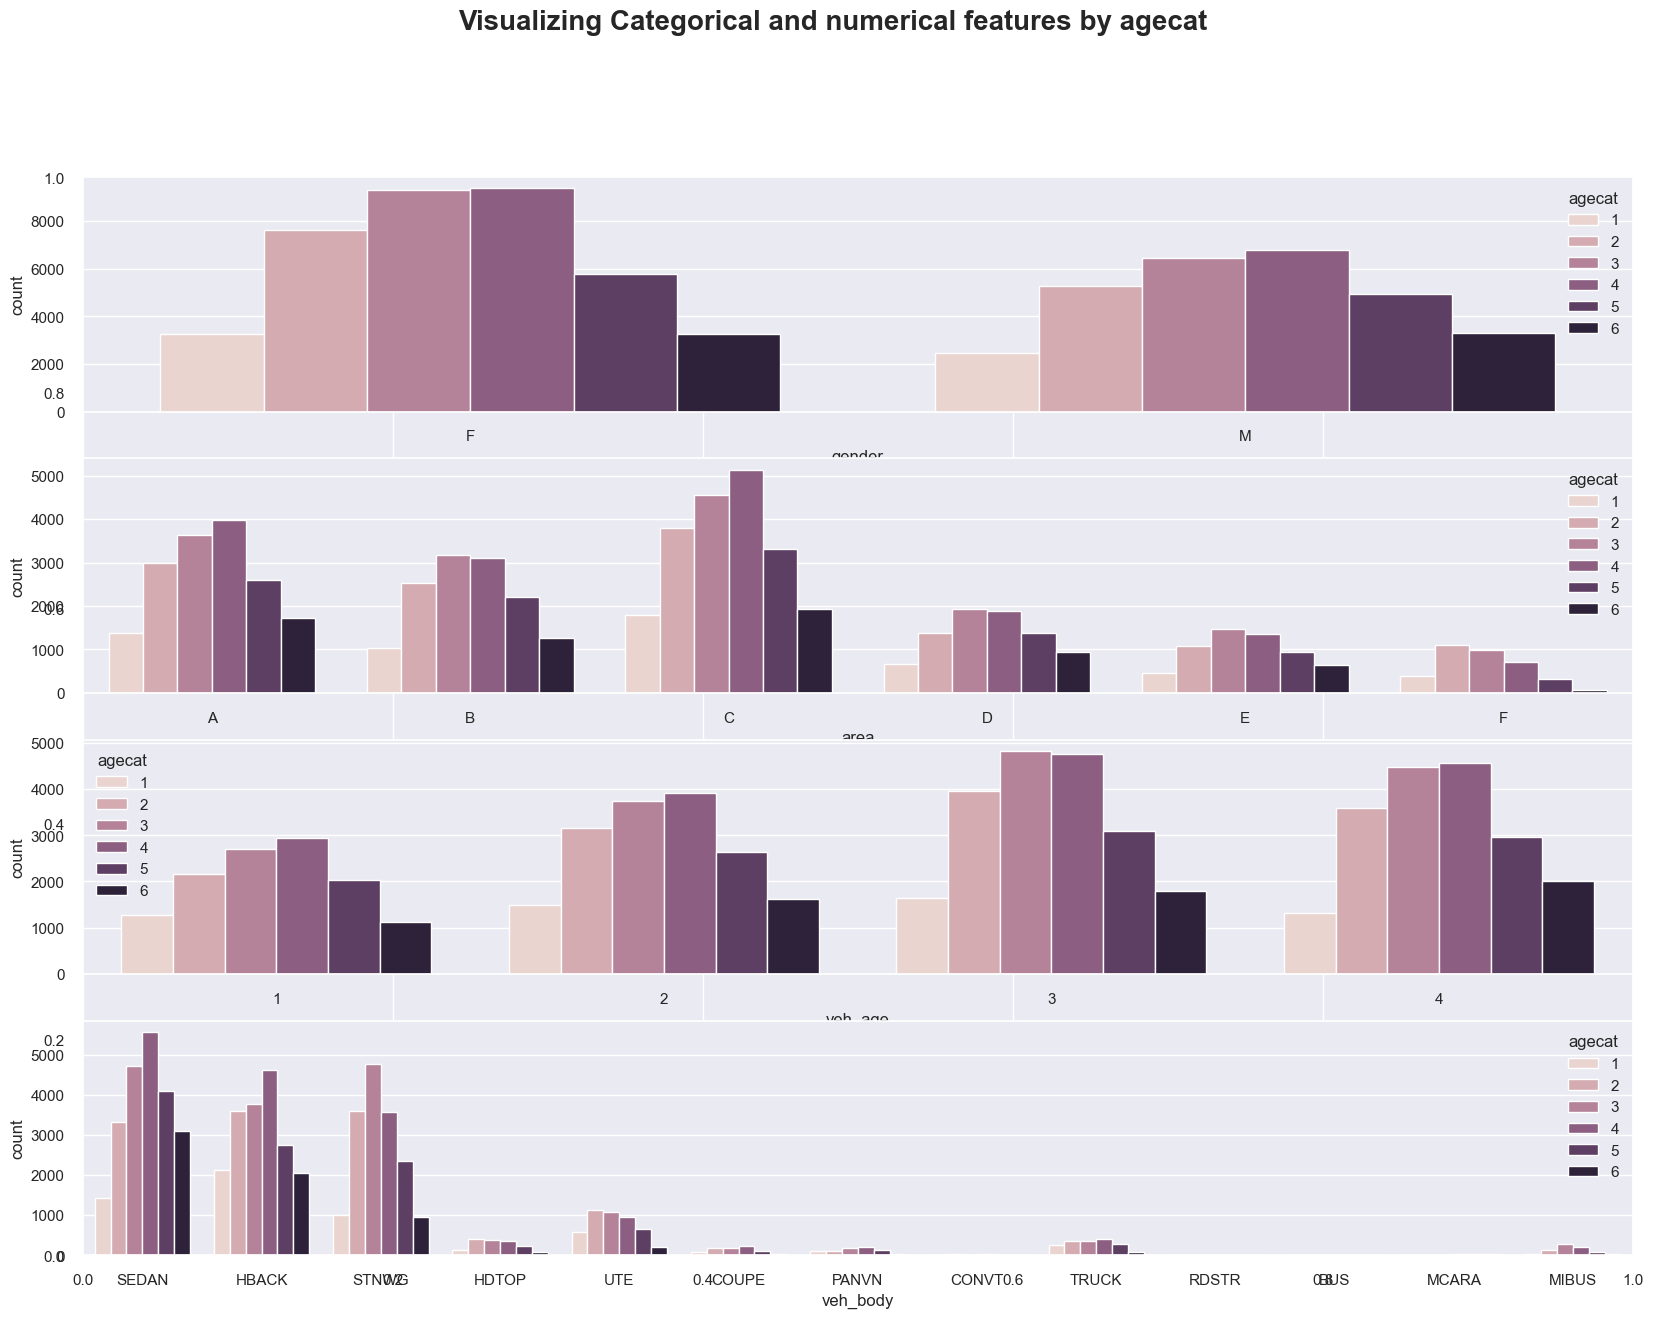

In [76]:
plt.subplots(figsize=(20,14))
plt.suptitle(f"Visualizing Categorical and numerical features by agecat",fontsize=20,fontweight="bold",y=1.)
plt.subplot(411)
sns.countplot(x="gender",hue="agecat",data=df)
plt.subplot(412)
sns.countplot(x="area",hue="agecat",data=df)
plt.subplot(413)
sns.countplot(x="veh_age",hue="agecat",data=df)
plt.subplot(414)
sns.countplot(x="veh_body",hue="agecat",data=df);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_agecat1.png',dpi=500);

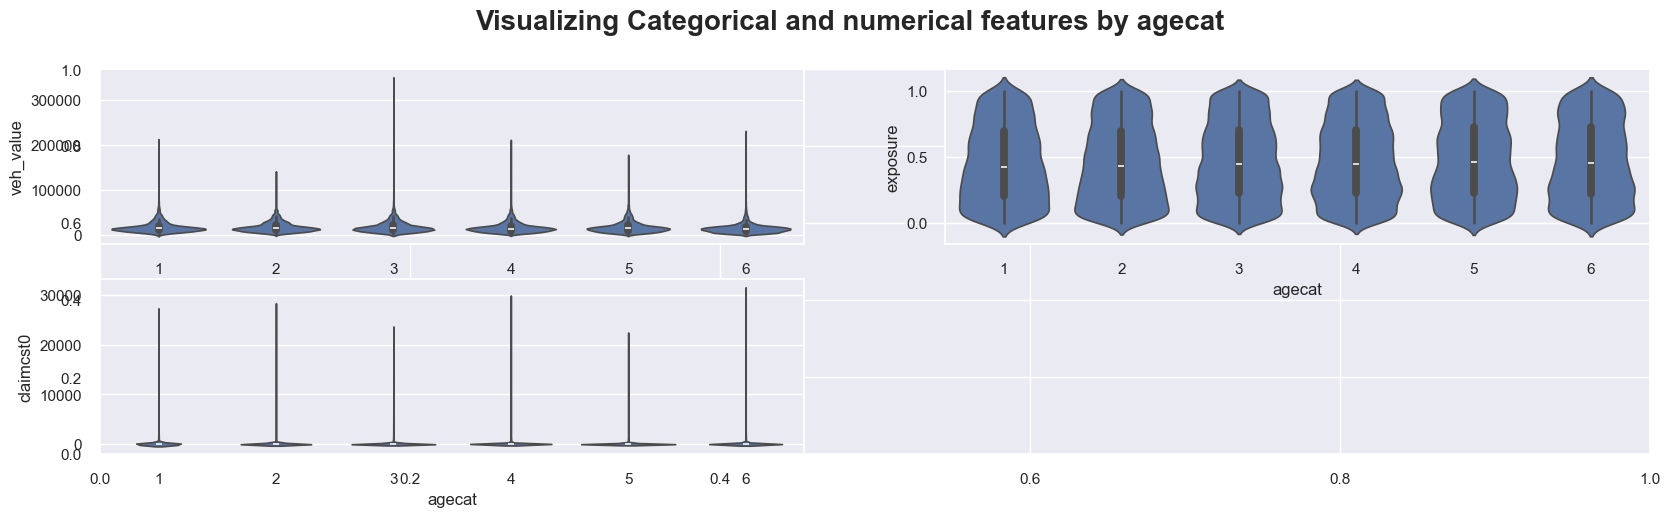

In [77]:
plt.subplots(figsize=(20,5))
plt.suptitle(f"Visualizing Categorical and numerical features by agecat",fontsize=20,fontweight="bold",y=1.)
plt.subplot(221)
sns.violinplot(x="agecat",y="veh_value",data=df)
plt.subplot(222)
sns.violinplot(x="agecat",y="exposure",data=df)
plt.subplot(223)
sns.violinplot(x="agecat",y="claimcst0",data=df)
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_agecat2.png',dpi=500);

---

In [79]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

*Define x and y*

In [80]:
x=df.drop("agecat",axis=1)
y=df["agecat"]

---

*Countinuous features Skewbess -outliers-*

In [81]:
x[countinuous_feature].skew(axis=0,skipna=True)

veh_value     2.974776
exposure      0.175452
claimcst0    13.879256
dtype: float64

---

*Transforming countinuous features to handle the outliers*

In [82]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value', 'claimcst0']
x_copy=pt.fit_transform(x[transform_features])

In [83]:
x_copy=pd.DataFrame(x_copy,columns=transform_features)
x_copy

,veh_value,claimcst0
0,0.102057,-0.270112
1,-0.035727,-0.270112
2,0.050345,-0.270112
3,0.081556,-0.270112
4,-0.091772,-0.270112
...,...,...
67790,-0.416781,-0.270112
67791,0.220262,-0.270112
67792,-3.017229,-0.270112
67793,-0.836256,-0.270112


In [84]:
x_copy.skew(axis=0,skipna=True)

veh_value    0.002599
claimcst0    3.432136
dtype: float64

---

*Visualizing  countinuous features after tranformation  :*

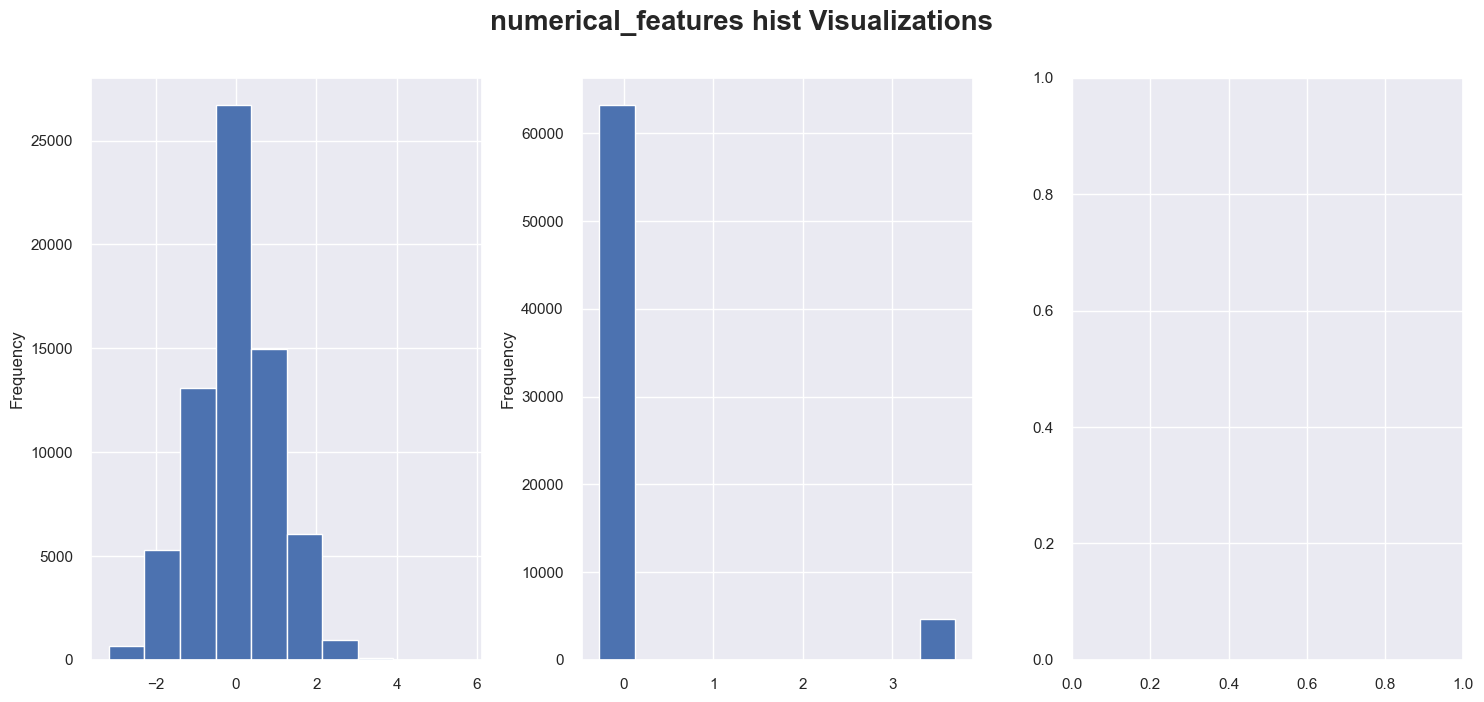

In [85]:
plot_numerical_features(x_copy[["veh_value","claimcst0"]],"hist")

---

In [86]:
for feature in categorical_features:
    print(feature,":",df[feature].unique())

veh_body : [ 9  3 10  4 12  2  7  1 11  8  0  5  6]
veh_age : [0 1 2 3]
gender : [0 1]
area : [0 1 2 3 4 5]
agecat : [0 1 2 3 4 5]


In [87]:
for feature in categorical_features:
    print(feature,":",df[feature].nunique())

veh_body : 13
veh_age : 4
gender : 2
area : 6
agecat : 6


---

*Apply ColumnTransformer to do all transdormation in once :*

In [88]:
from sklearn.preprocessing import PowerTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [89]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value', 'claimcst0']
df[transform_features]=pt.fit_transform(x[transform_features])

In [90]:
sc=StandardScaler()
onencood=OneHotEncoder()
ordinalencod=OrdinalEncoder()
transform_pipe=Pipeline(steps=[
    ("transformer",PowerTransformer(method="yeo-johnson"))
    ])

In [91]:
preprocessor=ColumnTransformer([
    #("OneHotEncoder",onencood,on_columns),
    #("Ordinal_Encoder",ordinalencod,ordered_columns),
    #("transformer",transform_pipe,transform_features),
    ("StandardScaler",sc,x.columns)
]
)

In [92]:
x=preprocessor.fit_transform(x)

---

*Hundling unbalanced data :*

In [93]:
from imblearn.combine import SMOTETomek,SMOTEENN
smt=SMOTEENN(random_state=42,sampling_strategy="minority")
x_re,y_res=smt.fit_resample(x,y)


---

*Split data into train and test subdata :*

In [94]:
x_train, x_test, y_train, y_test = train_test_split(x_re,y_res ,test_size= 0.2,random_state=42)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3449, 7) and Y = (3449,) : 
Test data shape of X = (863, 7) and Y = (863,) : 


---

*Define models :*

In [95]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "LogisticRegression":LogisticRegression(multi_class="ovr"),
        "SVC":SVC(decision_function_shape="ovr"),
        "KNeighborsClassifier":KNeighborsClassifier()
        
}

---

*Define evaluation funtion :*

In [96]:
def evaluation_preds_list(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    metrics_dict={
       "accuracy": round(accuracy,3),
          }
   
    return metrics_dict

In [97]:
def evaluation_preds(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    return accuracy

---

*Create one function to model the data :*

In [105]:
def evalua_models(x,y,models):
    x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20,random_state=42)
    models_list=[]
    accuracy_list=[]

    for i in  range(len(list(models))):
        model=list(models.values())[i]
        model.fit(x_train,y_train)

        train_predicted=model.predict(x_train)
        test_predicted=model.predict(x_test)      
        
        test_predicted_accuracy=evaluation_preds(y_test,test_predicted)
       
        accuracy_list.append(test_predicted_accuracy)
     

        #print(list(models.keys())[i])
        
        models_list.append(list(models.keys())[i])
        
        #print( test_predicted_accuracy)
        #print("===========================")
     

    report=pd.DataFrame(list(zip(models_list,accuracy_list)),columns=["model","acc"]).sort_values(by="acc",ascending=False) 
    return report
  

---

*Apply Data Modeling*

In [107]:
base_models=evalua_models(x_re,y_res,models)
base_models


,model,acc
2,RandomForestClassifier,0.902665
4,DecisionTreeClassifier,0.863268
1,GradientBoostingClassifier,0.862109
7,KNeighborsClassifier,0.852839
0,XGBRFClassifier,0.849363
6,SVC,0.836616
5,LogisticRegression,0.834299
3,AdaBoostClassifier,0.360371


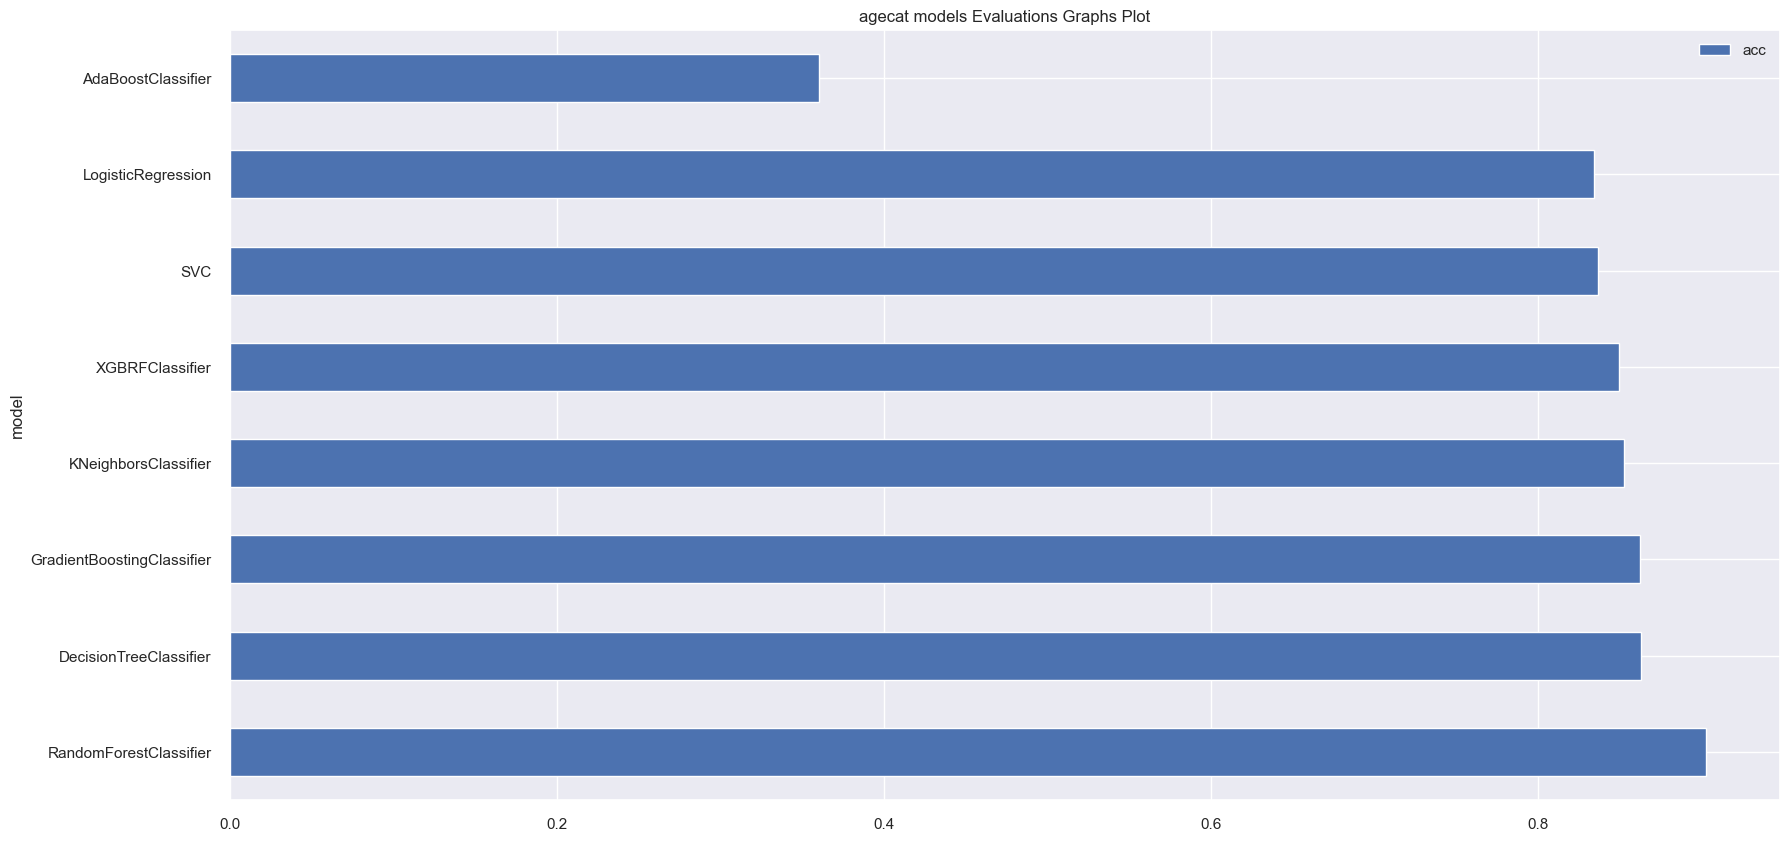

In [108]:
base_models.set_index("model").plot(kind="barh",figsize=(20,10),title="agecat models Evaluations Graphs Plot");
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/modelsEvaluationsGraphs/agecat_EvaluationsGraph.png',dpi=500);

---

*Apply RandomForestClassifier :*

In [109]:
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

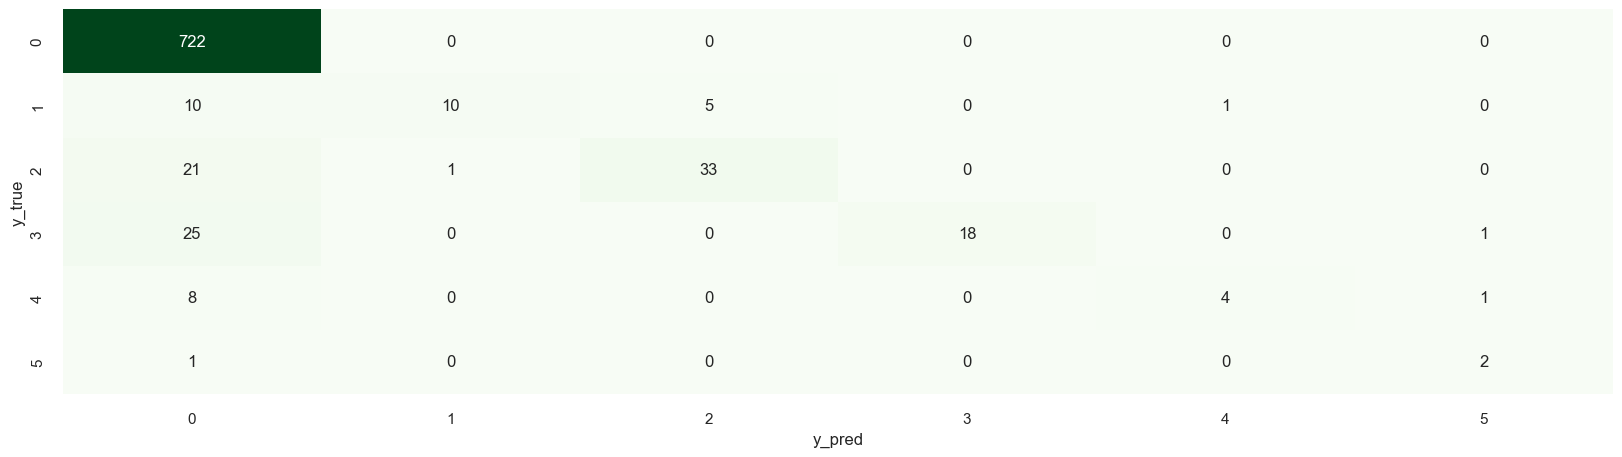

In [110]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True, fmt = ".0f",cbar=False,cmap="Greens")
plt.xlabel("y_pred")
plt.ylabel("y_true");
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/confusionMatrixGraphs/agecat_confusion_matrixPlot.png',dpi=500);

In [111]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       722
           1       0.91      0.38      0.54        26
           2       0.87      0.60      0.71        55
           3       1.00      0.41      0.58        44
           4       0.80      0.31      0.44        13
           5       0.50      0.67      0.57         3

    accuracy                           0.91       863
   macro avg       0.83      0.56      0.63       863
weighted avg       0.92      0.91      0.90       863



---

In [112]:
clf.feature_importances_.sum()

1.0000000000000002

In [113]:
clf.feature_names_in=list(df.drop("agecat",axis=1).columns)
importance=pd.concat([pd.DataFrame(clf.feature_names_in,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.313919
1,exposure,0.313179
2,claimcst0,0.026614
3,veh_body,0.132680
4,veh_age,0.063134
5,gender,0.033108
6,area,0.117365


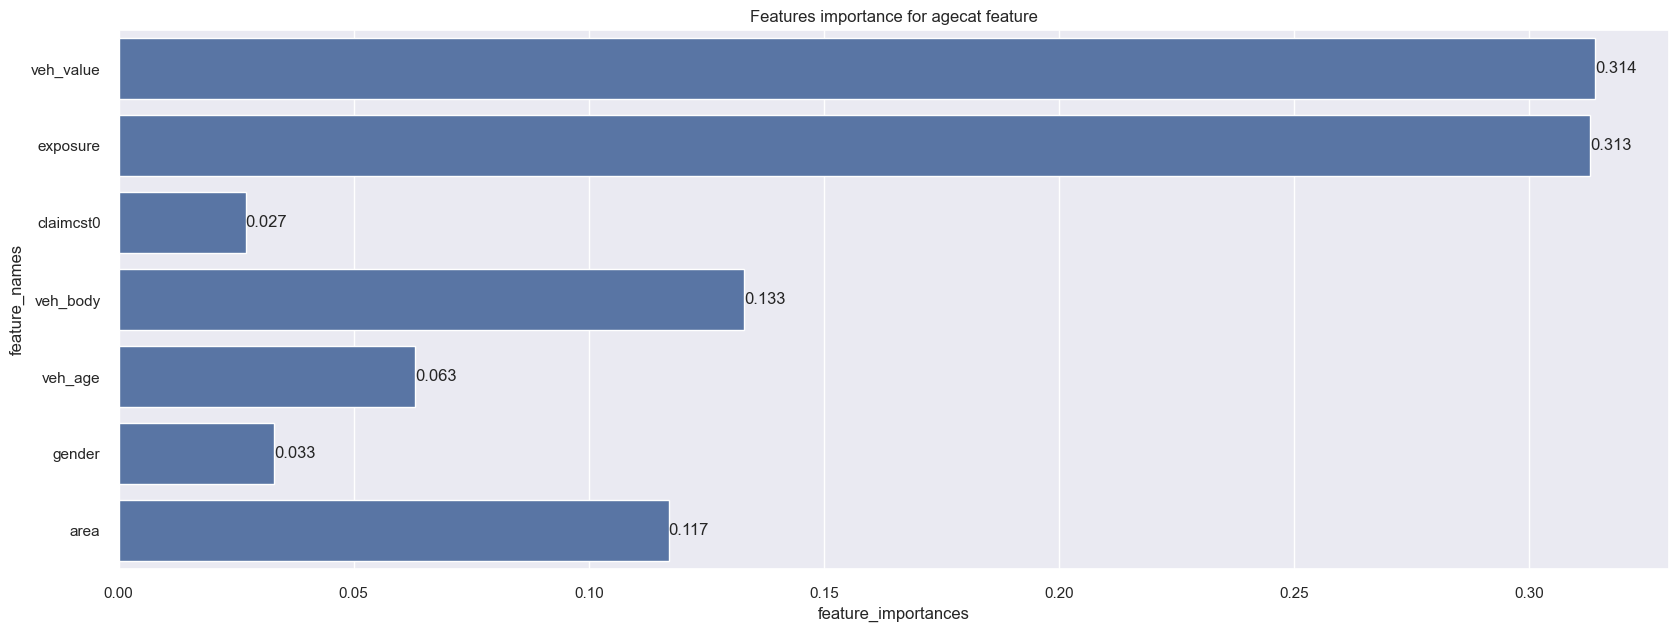

In [114]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for agecat feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/agecat_featureImportanc.png',dpi=500);

*Saving Best model :*

In [115]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/agecat_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)

---